### Best Practices for Model Evaluation and Hyperparameter Tuning

In [122]:
import pandas as pd
import numpy as np
from numpy import interp

from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample

# experimental
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

import scipy
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [37]:
df = pd.read_csv('../datasets/wdbc.data', header=None)

In [38]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [39]:
X = df.loc[:, 2:].values
y = df.loc[:, 1].values

In [40]:
le = LabelEncoder()
y = le.fit_transform(y)

In [41]:
le.classes_

array(['B', 'M'], dtype=object)

In [42]:
le.transform(['M', 'B'])

array([1, 0])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

In [44]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression())

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)

print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.956


#### Using k-fold cross-validation to assess model performance

In [45]:
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []

for k, (train, test) in enumerate(kfold):
    
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    
    scores.append(score)
    
    print(f'Fold: {k+1:02d}, 'f'Class distr.: {np.bincount(y_train[train])}, 'f'Acc.: {score:.3f}')

Fold: 01, Class distr.: [256 153], Acc.: 0.935
Fold: 02, Class distr.: [256 153], Acc.: 0.935
Fold: 03, Class distr.: [256 153], Acc.: 0.957
Fold: 04, Class distr.: [256 153], Acc.: 0.957
Fold: 05, Class distr.: [256 153], Acc.: 0.935
Fold: 06, Class distr.: [257 153], Acc.: 0.956
Fold: 07, Class distr.: [257 153], Acc.: 0.978
Fold: 08, Class distr.: [257 153], Acc.: 0.933
Fold: 09, Class distr.: [257 153], Acc.: 0.956
Fold: 10, Class distr.: [257 153], Acc.: 0.956


In [46]:
mean_acc = np.mean(scores)

In [47]:
std_acc = np.std(scores)

In [48]:
print(f'\nCV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')


CV accuracy: 0.950 +/- 0.014


In [49]:
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)

In [50]:
print(f'CV accuracy scores: {scores}')

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


In [51]:
print(f'CV accuracy: {np.mean(scores):.3f} 'f'+/- {np.std(scores):.3f}')

CV accuracy: 0.950 +/- 0.014


#### Diagnosing bias and variance problems with learning curves

In [54]:
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', max_iter=10000))

In [55]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)

In [56]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

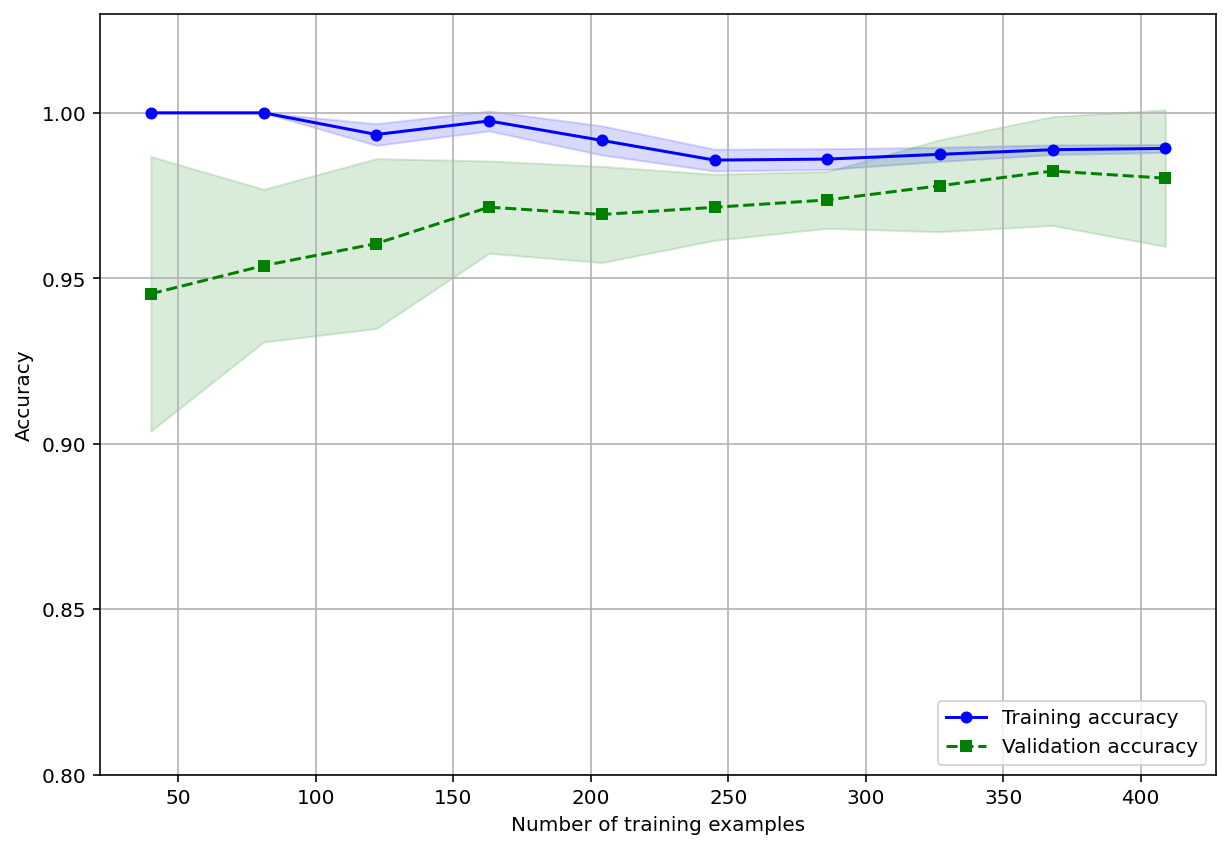

In [58]:
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

#### Addressing over- and underfitting with validation curves

In [60]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [61]:
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train,  y=y_train, param_name='logisticregression__C', param_range=param_range, cv=10)

In [62]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

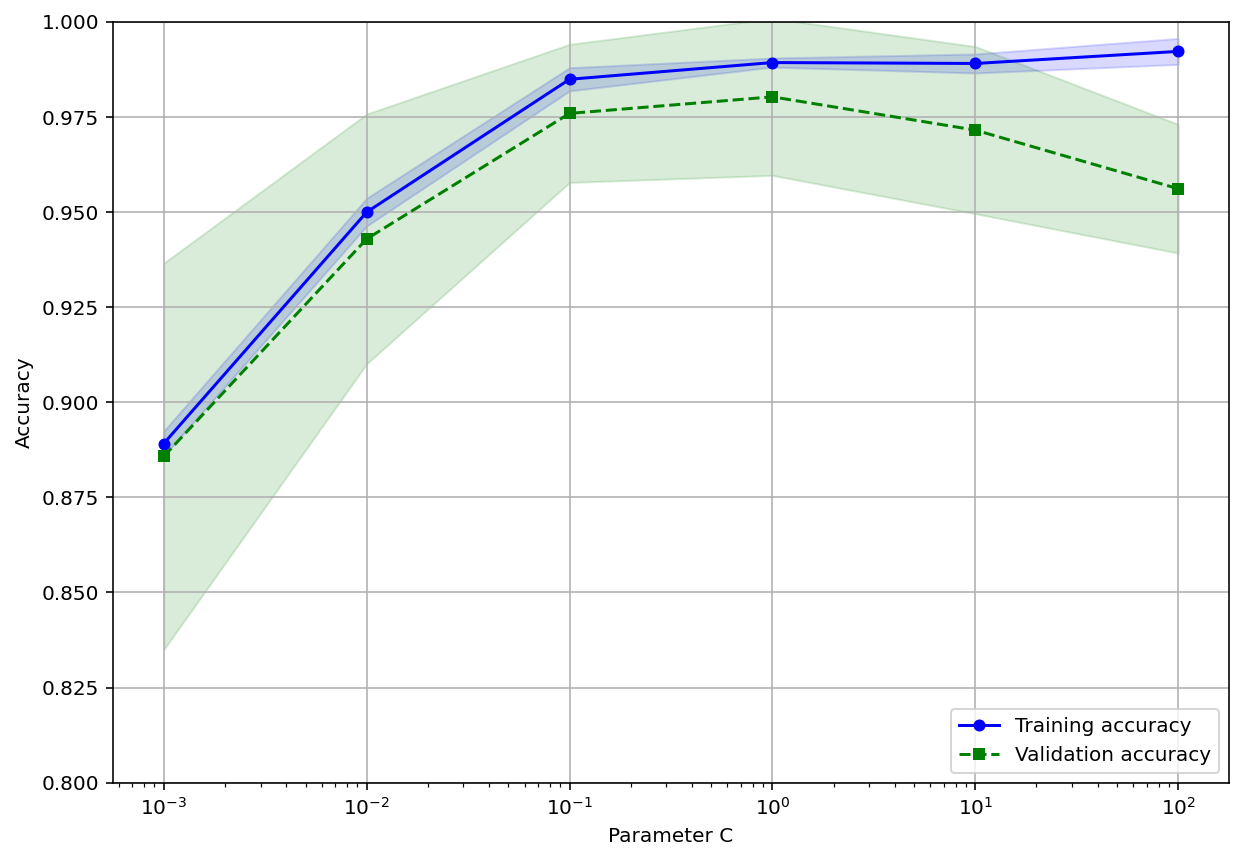

In [63]:
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

#### Fine-tuning machine learning models via grid search

In [65]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, refit=True, n_jobs=-1)
gs = gs.fit(X_train, y_train)

In [66]:
print(gs.best_score_)

0.9846859903381642


In [67]:
print(gs.best_params_)

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [69]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
 
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Test accuracy: 0.974


#### Exploring hyperparameter configurations more widely with randomized search

In [72]:
param_range = scipy.stats.loguniform(0.0001, 1000.0)

In [74]:
np.random.seed(1)

In [75]:
param_range.rvs(10)

array([8.30145146e-02, 1.10222804e+01, 1.00184520e-04, 1.30715777e-02,
       1.06485687e-03, 4.42965766e-04, 2.01289666e-03, 2.62376594e-02,
       5.98924832e-02, 5.91176467e-01])

In [77]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

In [78]:
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

In [79]:
rs = RandomizedSearchCV(estimator=pipe_svc, 
                        param_distributions=param_grid, 
                        scoring='accuracy', 
                        refit=True, n_iter=20, cv=10, random_state=1, n_jobs=-1)

In [80]:
rs = rs.fit(X_train, y_train)

In [81]:
print(rs.best_score_)

0.9780676328502416


In [82]:
print(rs.best_params_)

{'svc__C': 0.05971247755848464, 'svc__kernel': 'linear'}


#### More resource-efficient hyperparameter search with successive halving

In [86]:
hs = HalvingRandomSearchCV(pipe_svc, 
                           param_distributions=param_grid, 
                           n_candidates='exhaust', resource='n_samples', factor=1.5, random_state=1, n_jobs=-1)

In [87]:
hs = hs.fit(X_train, y_train)

In [88]:
print(hs.best_score_)

0.9617647058823529


In [89]:
print(hs.best_params_)

{'svc__C': 4.934834261073341, 'svc__kernel': 'linear'}


In [90]:
clf = hs.best_estimator_

In [91]:
print(f'Test accuracy: {hs.score(X_test, y_test):.3f}')

Test accuracy: 0.982


#### Algorithm selection with nested cross-validation

In [92]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

In [93]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,  scoring='accuracy', cv=2)

In [94]:
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print(f'CV accuracy: {np.mean(scores):.3f} 'f'+/- {np.std(scores):.3f}')

CV accuracy: 0.974 +/- 0.015


In [96]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), 
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}], scoring='accuracy', cv=2)

In [97]:
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print(f'CV accuracy: {np.mean(scores):.3f} 'f'+/- {np.std(scores):.3f}')

CV accuracy: 0.934 +/- 0.016


#### Confusion matrix

In [100]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


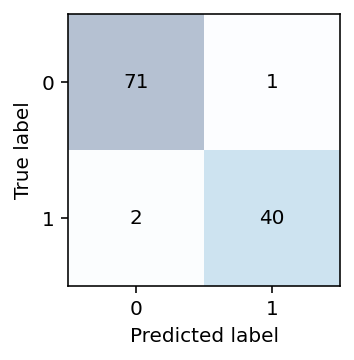

In [101]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [103]:
pre_val = precision_score(y_true=y_test, y_pred=y_pred)
print(f'Precision: {pre_val:.3f}')

Precision: 0.976


In [104]:
rec_val = recall_score(y_true=y_test, y_pred=y_pred)
print(f'Recall: {rec_val:.3f}')

Recall: 0.952


In [105]:
f1_val = f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1: {f1_val:.3f}')

F1: 0.964


In [106]:
mcc_val = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
print(f'MCC: {mcc_val:.3f}')

MCC: 0.943


In [109]:
c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range, 'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range, 'svc__gamma': c_gamma_range, 'svc__kernel': ['rbf']}]

In [110]:
scorer = make_scorer(f1_score, pos_label=0)

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10)
gs = gs.fit(X_train, y_train)

In [111]:
print(gs.best_score_)

0.9861994953378878


In [112]:
print(gs.best_params_)

{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


#### Plotting a receiver operating characteristic (ROC)

In [115]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2), LogisticRegression(penalty='l2', random_state=1, solver='lbfgs', C=100.0))

X_train2 = X_train[:, [4, 14]]

In [116]:
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

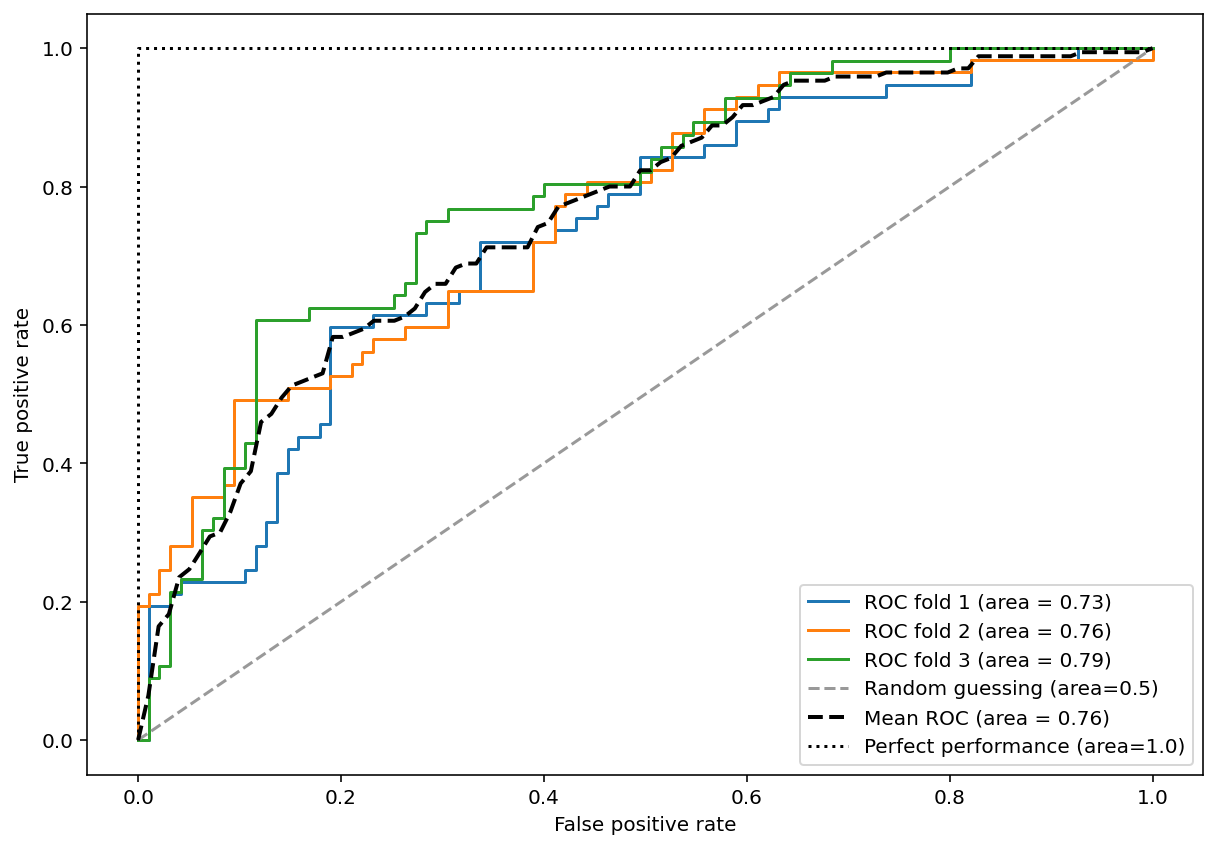

In [118]:
fig = plt.figure(figsize=(10, 7))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

all_tpr = []

for i, (train, test) in enumerate(cv):

    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)

    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance (area=1.0)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()

#### Scoring metrics for multiclass classification

In [119]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [120]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100 # accuracy

89.92443324937027

In [123]:
print('Number of class 1 examples before:', X_imb[y_imb == 1].shape[0])

Number of class 1 examples before: 40


In [125]:
# upsampling data
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], y_imb[y_imb == 1], replace=True, n_samples=X_imb[y_imb == 0].shape[0],  random_state=123)

In [126]:
print('Number of class 1 examples after:', X_upsampled.shape[0])

Number of class 1 examples after: 357


In [127]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [129]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100 # accuracy

50.0